In [13]:
import numpy as np
import os
import sys
import random
import torch
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path+"/models")
sys.path.append(module_path+"/train")
sys.path.append(module_path+"/experiments")
sys.path.append(module_path+"/datasets")

from factor_vae import FactorVAEDSprites, Discriminator
from beta_vae import Classifier
from datasets import train_test_random_split, load_dsprites, CustomDSpritesDatasetFactorVAE
from train import train_factor_vae, test_factor_vae
from entanglement_metric import entanglement_metric_factor_vae, entanglement_metric_beta_vae
from utils import load_checkpoint_factorvae, save_checkpoint_factorvae

In [14]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device.type

'cpu'

In [15]:
def plot_loss(loss_lists, title):
    if not isinstance(loss_lists[0], list):
        loss_lists = [loss_lists]
    for loss_list in loss_lists:
        plt.plot(np.arange(1,len(loss_list)+1, 1), loss_list)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training "+title)
    plt.show()

In [16]:
dataset = load_dsprites("../datasets/dsprites.npz",False)

In [17]:
data_size = 10000
data_ = CustomDSpritesDatasetFactorVAE(dataset,data_size)

In [18]:
data_train, data_test = train_test_random_split(data_, 0.8)
print("Training : "+str(len(data_train)))
print("Testing : "+str(len(data_test)))

Training : 8000
Testing : 2000


In [19]:
batch_size = 64
train_loader = DataLoader(data_train, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size,shuffle=False)

In [20]:
model = FactorVAEDSprites()
model.to(device)
discriminator = Discriminator(nb_layers=4,hidden_dim=500)
discriminator.to(device)
vae_optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-2)
discriminator_optimizer = torch.optim.Adagrad(discriminator.parameters(), lr=1e-2)
save_checkpoint_factorvae(model,discriminator,vae_optimizer,discriminator_optimizer,"checkpoint.pth.tar",0)
model, discriminator, vae_optimizer, discriminator_optimizer, start_epoch = load_checkpoint_factorvae(model, discriminator, vae_optimizer, discriminator_optimizer, filename='checkpoint.pth.tar')
gamma = 10
epochs = 5

=> loading checkpoint 'checkpoint.pth.tar'
=> loaded checkpoint 'checkpoint.pth.tar' (epoch 1)


In [9]:
train_losses_list, recon_losses_list, kl_divs_list, tc_losses_list, discriminator_losses_list = train_factor_vae(model, discriminator, epochs, train_loader, vae_optimizer, discriminator_optimizer, gamma, 'bernoulli',device=device)

/Users/ireneburger/opt/anaconda3/envs/atml/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 finished, loss: 1079.1437780761719, recon loss: 991.7829675292969, kl div: 145.59977993648127, TC loss: -5.82389992710948, discriminator loss: 3.719949877023697
Epoch 1 finished, loss: 350.5367294921875, recon loss: 326.32377514648437, kl div: 20.71990399169922, TC loss: 0.34930511032044886, discriminator loss: 0.612694896697998
Epoch 2 finished, loss: 275.8431143798828, recon loss: 250.73924475097655, kl div: 21.26544856262207, TC loss: 0.3838422356173396, discriminator loss: 0.5912971272468567
Epoch 3 finished, loss: 233.8025623779297, recon loss: 207.50773425292968, kl div: 21.169829040527343, TC loss: 0.5124999080151319, discriminator loss: 0.5528806688785552
Epoch 4 finished, loss: 199.8089442138672, recon loss: 175.21437841796876, kl div: 20.253890045166017, TC loss: 0.43406757044792177, discriminator loss: 0.5738126080036163


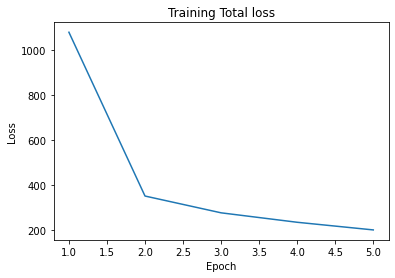

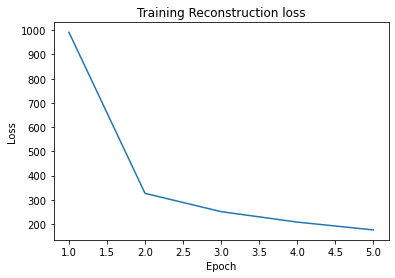

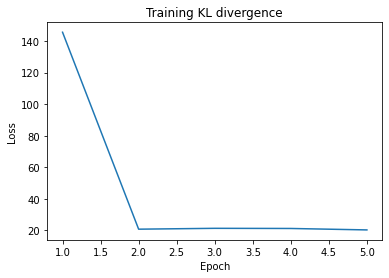

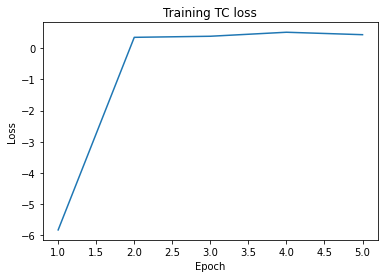

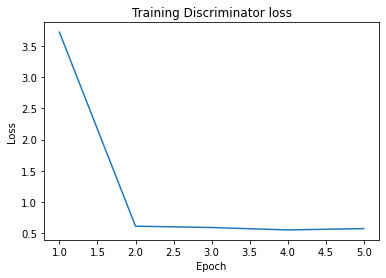

In [10]:
plot_loss(train_losses_list, "Total loss")
plot_loss(recon_losses_list, "Reconstruction loss")
plot_loss(kl_divs_list, "KL divergence")
plot_loss(tc_losses_list, "TC loss")
plot_loss(discriminator_losses_list, "Discriminator loss")

In [11]:
test_factor_vae(model, discriminator, test_loader, gamma, 'bernoulli', device=device)

/Users/ireneburger/opt/anaconda3/envs/atml/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test loss: 181.68307447433472


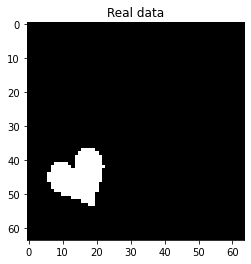

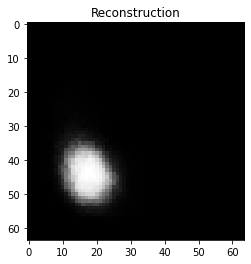

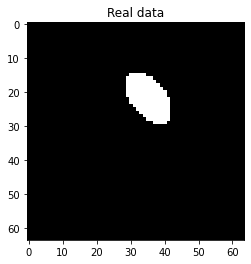

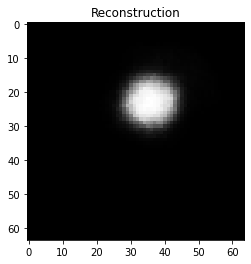

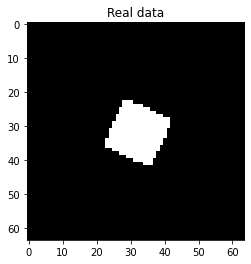

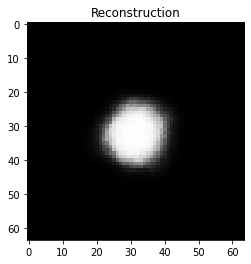

In [12]:
with torch.no_grad():
    for i in [1,2,20]:
        data, _ = data_test[i]
        data = data.float()
        if device != None:
            data = data.to(device)
        recon, mu, logvar, z = model(data)
        plt.imshow(data.cpu(), cmap='Greys_r')
        plt.title("Real data")
        plt.show()
        plt.imshow(torch.sigmoid(recon.squeeze().cpu()), cmap='Greys_r')
        plt.title("Reconstruction")
        plt.show()


Factor Vae metric: 
losses : [0.5866666666666667, 0.5333333333333333, 0.56, 0.47333333333333333, 0.47]
mean :0.5246666666666666
[[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
  [ 1.   8.8  4.8 12.8  5.2  5.   5.8  2.4  9.6  1.2]
  [ 1.   6.2  5.8 21.4  7.   5.2  3.8  1.2  9.6  2.6]
  [ 1.6 10.4  5.   9.8  3.   4.4  7.6  1.4 10.8  2.8]
  [43.2  0.   0.   4.2  0.   0.   0.   0.  11.4  0. ]
  [ 0.   9.   4.2  0.   0.6  0.   0.2  0.   0.  50. ]]]
Accuracy: 0.4753333333333334
Beta Vae metric: 
Accuracy: 0.58


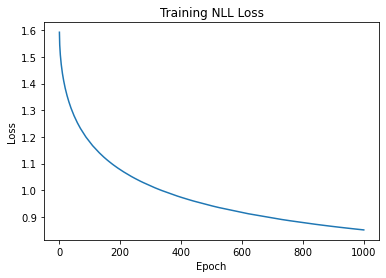

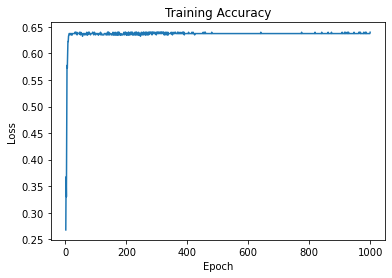

In [10]:
print("Factor Vae metric: ")
loss = entanglement_metric_factor_vae(model, data_, 300, 200, random_seeds=5)
print("Accuracy: "+str(1-loss))
print("Beta Vae metric: ")
classifier = Classifier()
optimizer = torch.optim.Adagrad(classifier.parameters(), lr=1e-2)
train_losses, train_accuracies, test_accuracy = entanglement_metric_beta_vae(model, classifier, optimizer, 1000,  data_, 500, 50, random_seeds=1)
print("Accuracy: "+str(test_accuracy))
plot_loss(train_losses, "NLL Loss")
plot_loss(train_accuracies, "Accuracy")